## 311 complaints analysis

The 311 dataset contains all the non-emergency complaints/service requests covering a wide range of city agencies like Department of Sanitation, Housing, Transportation, NYPD etc. Some common complaints include sidewalk and road repairs, noise, graffiti and others. Depending on the service request, city agencies will answer the question or send municipal services to the location to fix the problem. 

The detailed 311 data for NYC from 2010 onwards is available with open access: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

Owing to the large scale of 311 data, it is quite helpful in analyzing the city-wide trends/anomalies from different perspectives. In this notebook, we'll demonstrate some steps necessary to pre-process the data as well some cases which can help identify the patterns in urban economy. In particular, this notebook contains:

- Important sanity checks for cleaning and pre-processing the data

- Cases with analysis of 311 data with income/real estate data to identify patterns in 311 as a signature of urban economy
- Working with geopandas for plotting data in maps

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# read the 311 data for 2019 (this data contains only sepcific columns we use in this lab)

data = pd.read_csv('/home/jovyan/shared/Data/311_2019.csv')

# convert complaint date to datetime format
data['Created Date'] = pd.to_datetime(data['Created Date'])
data.head()

/opt/conda/envs/PUI/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unique Key,Created Date,Agency,Complaint Type,Location Type,Incident Zip,Latitude,Longitude,Location
0,43162639,2019-06-29 13:05:22,TLC,Taxi Complaint,NaN,NaN,NaN,NaN,NaN
1,44079566,2019-10-17 08:25:14,DPR,Damaged Tree,Street/Curbside,11434.0,40.670854,-73.771876,"(40.6708540271649, -73.77187597753328)"
2,45211021,2019-12-20 06:54:38,DSNY,Graffiti,Mixed Use,11212.0,40.663072,-73.925752,"(40.66307167932628, -73.92575181328998)"
3,45232110,2019-12-23 08:48:30,DSNY,Graffiti,Mixed Use,10016.0,40.744629,-73.976001,"(40.74462912186954, -73.97600102823421)"
4,43573777,2019-08-17 02:30:39,DSNY,Graffiti,Residential,10032.0,40.835618,-73.945652,"(40.83561762599567, -73.9456520072136)"


Column descriptions:

- Unique Key: unique number for a 311 call/request data point

- Created Date: date and time of the call

- Agency: name of city agency the call is attributed to

- Complaint type: description of the compaint

- Latitude/Longitude/Location: coordinates of the 311 complaints

There are other columns in the complete 311 data like Status, Intersection Name, etc. which are not included here in this notebook. Please check the complete 311 documentation from NYC open data for details.

In [3]:
data.shape

(802745, 9)

### Data cleaning and sanity checks

#### The data may have a lot of errors/missing records. We'll try to diagnose these issues and remove the concerned rows 

In [4]:
# first - let's check the unique zip codes in the data

data['Incident Zip'].unique()

array([nan, 11434.0, 11212.0, 10016.0, 10032.0, 11420.0, 11105.0, 10470.0,
       10461.0, 10454.0, 11226.0, 11357.0, 10019.0, 10035.0, 11218.0,
       11694.0, 10022.0, 11419.0, 11385.0, 11216.0, 11207.0, 10034.0,
       11375.0, 11374.0, 11411.0, 11106.0, 11220.0, 10305.0, 11430.0,
       10017.0, 11372.0, 11201.0, 10453.0, 11358.0, 11421.0, 11223.0,
       11691.0, 11368.0, 10306.0, 11436.0, 10304.0, 10027.0, 10452.0,
       10466.0, 11203.0, 11210.0, 11214.0, 10459.0, 11423.0, 11432.0,
       11236.0, 10463.0, 11208.0, 10028.0, 10469.0, 11249.0, 11238.0,
       10033.0, 11229.0, 10465.0, 11370.0, 10024.0, 11234.0, 11356.0,
       11377.0, 11206.0, 11418.0, 11414.0, 10307.0, 10460.0, 11412.0,
       11233.0, 11415.0, 10039.0, 11232.0, 11213.0, 11222.0, 11378.0,
       11427.0, 11422.0, 11228.0, 11413.0, 10002.0, 11104.0, 11215.0,
       11364.0, 10023.0, 10025.0, 11235.0, 11367.0, 11379.0, 11231.0,
       11365.0, 10003.0, 11209.0, 10014.0, 11435.0, 11354.0, 10031.0,
       10467.0,

The data has many nan values as well as codes which are obvious errors (example - "7030", "W1" etc.)

In [5]:
# filter out nans

data.dropna(subset=['Incident Zip'], inplace=True)

In [6]:
# convert the zip codes to numeric type - this will remove all word (string) zips

data['Incident Zip'] = pd.to_numeric(data['Incident Zip'], errors='coerce')

In [7]:
# !git clone https://github.com/CUSP2021-FallPUI/Labs.git

In [8]:
# next - read the NYC zip code shapefile filter the 311 data to keep only NYC zips

zips = gpd.read_file('ZIPCODE/ZIP_CODE_040114.shp')
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [9]:
data = data[data['Incident Zip'].isin(zips.ZIPCODE)]
data.shape

(766126, 9)

~ 4% records are filtered out

In [10]:
# get hour of complaint (from the datetime)

data['complaint_hour'] = data['Created Date'].dt.hour
data.head()

,Unique Key,Created Date,Agency,Complaint Type,Location Type,Incident Zip,Latitude,Longitude,Location,complaint_hour
1,44079566,2019-10-17 08:25:14,DPR,Damaged Tree,Street/Curbside,11434.0,40.670854,-73.771876,"(40.6708540271649, -73.77187597753328)",8
2,45211021,2019-12-20 06:54:38,DSNY,Graffiti,Mixed Use,11212.0,40.663072,-73.925752,"(40.66307167932628, -73.92575181328998)",6
3,45232110,2019-12-23 08:48:30,DSNY,Graffiti,Mixed Use,10016.0,40.744629,-73.976001,"(40.74462912186954, -73.97600102823421)",8
4,43573777,2019-08-17 02:30:39,DSNY,Graffiti,Residential,10032.0,40.835618,-73.945652,"(40.83561762599567, -73.9456520072136)",2
5,43524214,2019-08-11 23:46:01,NYPD,Noise - Commercial,Store/Commercial,11420.0,40.675929,-73.818015,"(40.67592902161404, -73.81801548500097)",23


/opt/conda/envs/PUI/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='complaint_hour', ylabel='count'>

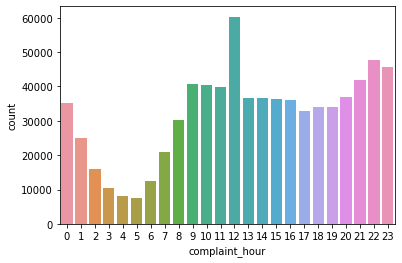

In [11]:
# check the complaint volume by hour

sns.countplot(data.complaint_hour)

unusually high number of complaints at noon, probably due to some error in assigning times to the calls. Let's check the complaints at noon

In [12]:
data['complaint_time'] = data['Created Date'].dt.time
len(data[data.complaint_time == datetime.time(12, 0, 0)])

21013

~ 21k complaints are assigned at exact noon, which is quite high considering the number of complaints surrounding noon times (11am, 1pm), which are around ~40k. So, it is very likely that the exact noon (12:00:00) complaints are not legit.

In [13]:
# remove the excess noon complaints from the data

data = data[~(data['complaint_time'] == datetime.time(12, 0, 0))]
data.shape

(745113, 11)

In [14]:
# next, check the number of total complaints in 2019 by zipcode

byZip = data.groupby(by='Incident Zip', as_index=False).count()[['Incident Zip', 'Unique Key']].rename(columns={'Unique Key':'N_complaints'})
byZip

,Incident Zip,N_complaints
0,83.0,4
1,10001.0,4819
2,10002.0,7769
3,10003.0,7398
4,10004.0,1401
...,...,...
225,11691.0,3214
226,11692.0,911
227,11693.0,989
228,11694.0,1985


Text(0.5, 1.0, '311 complaints by zip code')

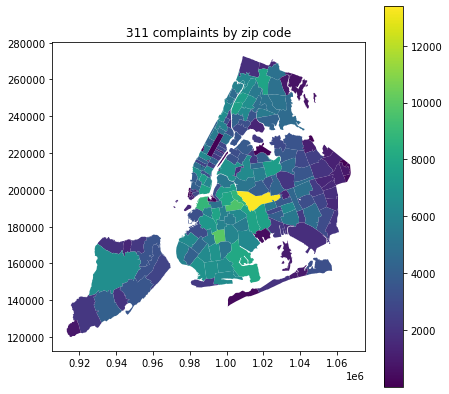

In [15]:
# plot as a heatmap

byZip_plot = zips.merge(byZip, left_on='ZIPCODE', right_on='Incident Zip')
byZip_plot.plot(column='N_complaints', figsize=(7,7), legend=True)
plt.title('311 complaints by zip code')

let's further calculate the normalized number of complaints by zipcode. We'll use area for normalization here.

Text(0.5, 1.0, 'normalized 311 complaints (by area) by zip code')

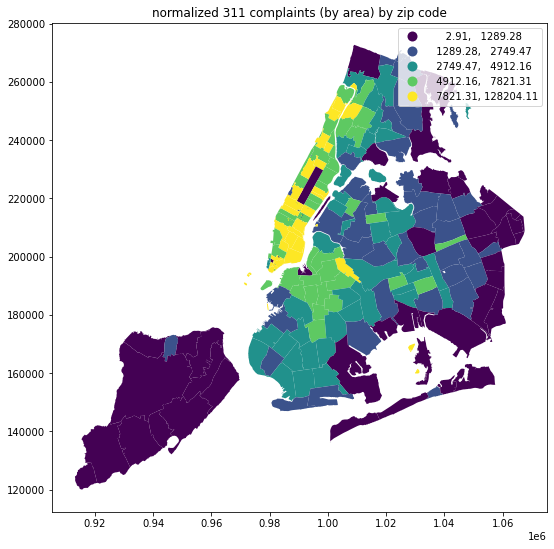

In [16]:
# normalize number of complaints by area and plot

# convert sq.ft. to sq.miles
byZip_plot['area_sqMile'] = byZip_plot['AREA']/27880000
# divide by area
byZip_plot['complaints_norm'] = byZip_plot['N_complaints']/byZip_plot['area_sqMile']
byZip_plot.plot(column='complaints_norm', figsize=(9,9), scheme='quantiles', legend=True)
plt.title('normalized 311 complaints (by area) by zip code')

In [17]:
byZip.sort_values(by='N_complaints')

,Incident Zip,N_complaints
48,10096.0,1
47,10080.0,1
76,10171.0,2
43,10055.0,3
68,10155.0,3
...,...,...
171,11237.0,8768
137,11201.0,8888
156,11221.0,9672
161,11226.0,9937


many zip codes have just a small number of 311 requests for the year. Let's keep only the zipcodes there are at least 100 complaints.

In [18]:
# number of zips with >100 311 complaints

byZip[byZip.N_complaints > 100].shape

(184, 2)

In [19]:
# keep only the zips with >100 complaints

data = data[data['Incident Zip'].isin(byZip[byZip.N_complaints > 100]['Incident Zip'])]

In [20]:
data.shape

(744284, 11)

~ 0.1% records further removed

## Business-time complaints vs per-capita income

The areas with high commercial activity may have high real estate pricing and consequently high income people living there. 

Let's check if there is any relation between the number of complaints during business hours (9am-6pm) and per capita income in a neighborhood. 

In [21]:
# get day of week from the date (0-5 are weekdays, 5 and 6 are weekends)

data['weekday'] = data['Created Date'].dt.weekday
data.head()

,Unique Key,Created Date,Agency,Complaint Type,Location Type,Incident Zip,Latitude,Longitude,Location,complaint_hour,complaint_time,weekday
1,44079566,2019-10-17 08:25:14,DPR,Damaged Tree,Street/Curbside,11434.0,40.670854,-73.771876,"(40.6708540271649, -73.77187597753328)",8,08:25:14,3
2,45211021,2019-12-20 06:54:38,DSNY,Graffiti,Mixed Use,11212.0,40.663072,-73.925752,"(40.66307167932628, -73.92575181328998)",6,06:54:38,4
3,45232110,2019-12-23 08:48:30,DSNY,Graffiti,Mixed Use,10016.0,40.744629,-73.976001,"(40.74462912186954, -73.97600102823421)",8,08:48:30,0
4,43573777,2019-08-17 02:30:39,DSNY,Graffiti,Residential,10032.0,40.835618,-73.945652,"(40.83561762599567, -73.9456520072136)",2,02:30:39,5
5,43524214,2019-08-11 23:46:01,NYPD,Noise - Commercial,Store/Commercial,11420.0,40.675929,-73.818015,"(40.67592902161404, -73.81801548500097)",23,23:46:01,6


In [22]:
# make another column describing business time complaints as "business_time"

# mon-fri
business_days = [0, 1, 2, 3, 4]

data['complaint_description'] = 'other'

# attribute 9am-6pm complaints on weekdays as business time complaints
data.loc[(data.complaint_hour > 8) & (data.complaint_hour < 19) & (data.weekday.isin(business_days)), 
         'complaint_description'] = 'business_time'
data.head()

,Unique Key,Created Date,Agency,Complaint Type,Location Type,Incident Zip,Latitude,Longitude,Location,complaint_hour,complaint_time,weekday,complaint_description
1,44079566,2019-10-17 08:25:14,DPR,Damaged Tree,Street/Curbside,11434.0,40.670854,-73.771876,"(40.6708540271649, -73.77187597753328)",8,08:25:14,3,other
2,45211021,2019-12-20 06:54:38,DSNY,Graffiti,Mixed Use,11212.0,40.663072,-73.925752,"(40.66307167932628, -73.92575181328998)",6,06:54:38,4,other
3,45232110,2019-12-23 08:48:30,DSNY,Graffiti,Mixed Use,10016.0,40.744629,-73.976001,"(40.74462912186954, -73.97600102823421)",8,08:48:30,0,other
4,43573777,2019-08-17 02:30:39,DSNY,Graffiti,Residential,10032.0,40.835618,-73.945652,"(40.83561762599567, -73.9456520072136)",2,02:30:39,5,other
5,43524214,2019-08-11 23:46:01,NYPD,Noise - Commercial,Store/Commercial,11420.0,40.675929,-73.818015,"(40.67592902161404, -73.81801548500097)",23,23:46:01,6,other


/opt/conda/envs/PUI/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='complaint_description', ylabel='count'>

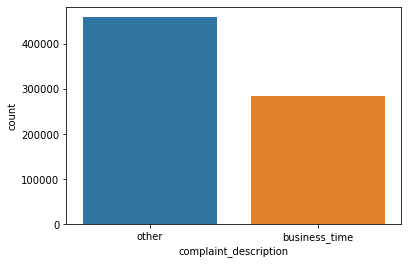

In [23]:
# number of complaints business time vs others

sns.countplot(data.complaint_description)

In [24]:
# now calculate the business time complaints as a % of total 311 complaints for each zip code

complaint_perc = data.groupby(by=['Incident Zip', 'complaint_description']).count()[['Unique Key']]
complaint_perc = complaint_perc.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
complaint_perc.reset_index(inplace=True)
complaint_perc.rename(columns={'Unique Key':'perc_complaints'}, inplace=True)
complaint_perc.head()

,Incident Zip,complaint_description,perc_complaints
0,10001.0,business_time,43.369994
1,10001.0,other,56.630006
2,10002.0,business_time,38.010040
3,10002.0,other,61.989960
4,10003.0,business_time,39.497161


In [25]:
# 2019 income data (in USD) per zip code - retrieved from official US census www.census.gov

income = pd.read_csv('https://raw.githubusercontent.com/CUSP2021-FallPUI/Labs/main/IncomeEduReg.csv')
income = income[['Zipcode', 'IncomePerCapita']]
income.head()

,Zipcode,IncomePerCapita
0,10001,77512.0
1,10002,26905.0
2,10003,79088.0
3,10004,98020.0
4,10005,99633.0


In [26]:
# merge the median sale price data with 311 business time % complaints

complaint_perc_bus = complaint_perc.loc[complaint_perc.complaint_description == 'business_time', :]
comp_sales = complaint_perc_bus.merge(income, left_on='Incident Zip', right_on='Zipcode')
comp_sales.head()

,Incident Zip,complaint_description,perc_complaints,Zipcode,IncomePerCapita
0,10001.0,business_time,43.369994,10001,77512.0
1,10002.0,business_time,38.010040,10002,26905.0
2,10003.0,business_time,39.497161,10003,79088.0
3,10004.0,business_time,52.676660,10004,98020.0
4,10005.0,business_time,55.334988,10005,99633.0


In [27]:
# correlation

comp_sales[['perc_complaints', 'IncomePerCapita']].corr()

,perc_complaints,IncomePerCapita
perc_complaints,1.000000,0.442813
IncomePerCapita,0.442813,1.000000


~ 0.44 

Text(0.5, 1.0, '% business time complaints')

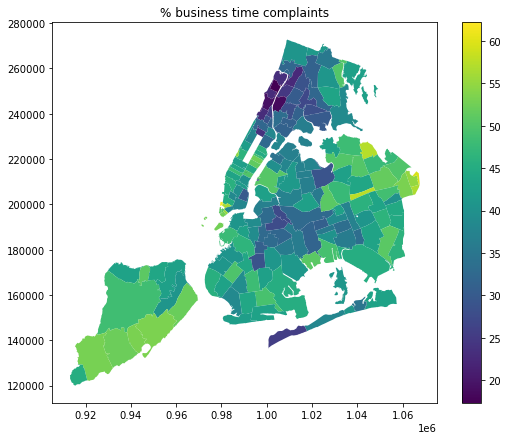

In [28]:
# plot in a heatmap

comp_sales_plot = zips.merge(comp_sales, left_on='ZIPCODE', right_on='Incident Zip')
comp_sales_plot.plot(column='perc_complaints', figsize=(9,7), legend=True)
plt.title('% business time complaints')

Text(0.5, 1.0, 'income per capita')

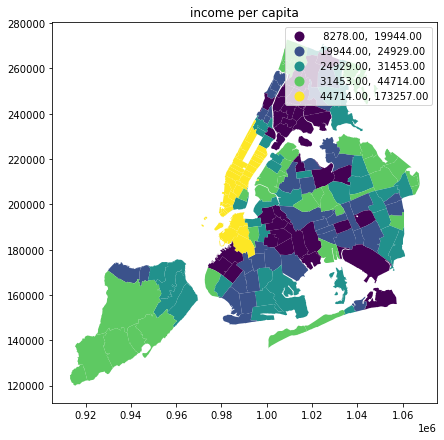

In [29]:
# income

comp_sales_plot.plot(column='IncomePerCapita', scheme='quantiles', figsize=(9,7), legend=True)
plt.title('income per capita')

We do see some neighborhoods in Brooklyn, Bronx and Upper Manhattan where income correlates with the commercial 311 complaints.

## All business complaints vs. real estate

Next, we'll see if there's any relation between all 311 complaints attributed to business/commercial spaces and the real estate market in an area.

In [30]:
# check unique location type present in data

data['Location Type'].unique()

array(['Street/Curbside', 'Mixed Use', 'Residential', 'Store/Commercial',
       nan, 'Comercial', 'Street', '1-2 Family Dwelling',
       'Street/Sidewalk', 'Bike Lane', 'Residential Building/House',
       'Sidewalk', 'Above Address', 'Taxi', 'Other (Explain Below)',
       'Commercial Building', 'Park', 'Club/Bar/Restaurant',
       'Park/Playground', 'Property Address', '1-, 2- and 3- Family Home',
       'Co-Op Unit', 'Senior Address', 'Condo Unit', 'Address',
       'Government/Not-for Profit', 'Commercial', 'RESIDENTIAL BUILDING',
       'Apartment Building', 'Beach', 'Pool',
       '3+ Family Apartment Building', 'Residential Building',
       'Street Area', 'Construction Site', 'Restaurant/Bar/Deli/Bakery',
       'Mobile Food Vendor', 'Curb', 'Catch Basin/Sewer',
       'Food Cart Vendor', '3+ Family Apt. Building',
       '3+ Family Mixed Use Building', 'House of Worship',
       '1-2 Family Mixed Use Building', 'Bus Stop Shelter', 'Other',
       'Vacant Lot', 'Tattoo Parlo

For business/commercial spaces, we'll consider commercial buildings, restaurants, stores, clubs etc.

In [31]:
# all business locations

business_loc = ['Commercial Building', 'Restaurant/Bar/Deli/Bakery', 'Building (Non-Residential)', 
               'Club/Bar/Restaurant', 'Restaurant', 'Commercial', 'Store', 'Food Establishment', 'Store/Commercial']

In [32]:
# make another column for location description - "business" and "other"

data['loc_description'] = 'other'
data.loc[data['Location Type'].isin(business_loc), 'loc_description'] = 'business'
data.head()

,Unique Key,Created Date,Agency,Complaint Type,Location Type,Incident Zip,Latitude,Longitude,Location,complaint_hour,complaint_time,weekday,complaint_description,loc_description
1,44079566,2019-10-17 08:25:14,DPR,Damaged Tree,Street/Curbside,11434.0,40.670854,-73.771876,"(40.6708540271649, -73.77187597753328)",8,08:25:14,3,other,other
2,45211021,2019-12-20 06:54:38,DSNY,Graffiti,Mixed Use,11212.0,40.663072,-73.925752,"(40.66307167932628, -73.92575181328998)",6,06:54:38,4,other,other
3,45232110,2019-12-23 08:48:30,DSNY,Graffiti,Mixed Use,10016.0,40.744629,-73.976001,"(40.74462912186954, -73.97600102823421)",8,08:48:30,0,other,other
4,43573777,2019-08-17 02:30:39,DSNY,Graffiti,Residential,10032.0,40.835618,-73.945652,"(40.83561762599567, -73.9456520072136)",2,02:30:39,5,other,other
5,43524214,2019-08-11 23:46:01,NYPD,Noise - Commercial,Store/Commercial,11420.0,40.675929,-73.818015,"(40.67592902161404, -73.81801548500097)",23,23:46:01,6,other,business


In [33]:
# % of business complaints by zipcode

complaint_perc = data.groupby(by=['Incident Zip', 'loc_description']).count()[['Unique Key']]
complaint_perc = complaint_perc.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
complaint_perc.reset_index(inplace=True)
complaint_perc.rename(columns={'Unique Key':'perc_complaints'}, inplace=True)
complaint_perc.head()

,Incident Zip,loc_description,perc_complaints
0,10001.0,business,8.798506
1,10001.0,other,91.201494
2,10002.0,business,8.636890
3,10002.0,other,91.363110
4,10003.0,business,8.313058


In [34]:
# !unzip Labs/real_estate.csv.zip real_estate.csv

In [35]:
# NYC house sales data

sales = pd.read_csv('/home/jovyan/shared/Labs/Lab2_311case/real_estate.csv')
sales.head()

,BOROUGH,BLOCK,LOT,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10
1,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,750000,2017-06-16
2,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10
3,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,730000,2017-08-23
4,4,976,15,01 ONE FAMILY DWELLINGS,21-20 81ST STREET,11370.0,1224.0,1950.0,792000,2017-07-26


In [36]:
# calculate price per sq.ft.

sales['price_perSqf'] = sales['SALE PRICE']/sales['GROSS SQUARE FEET']
sales.head()

,BOROUGH,BLOCK,LOT,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,price_perSqf
0,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10,490.196078
1,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,750000,2017-06-16,612.745098
2,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10,490.196078
3,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,730000,2017-08-23,596.405229
4,4,976,15,01 ONE FAMILY DWELLINGS,21-20 81ST STREET,11370.0,1224.0,1950.0,792000,2017-07-26,647.058824


In [37]:
# calculate the median price by zipcode

sales_median = sales.groupby(by='ZIP CODE', as_index=False).median()[['ZIP CODE', 'price_perSqf']]
sales_median.head()

,ZIP CODE,price_perSqf
0,10001.0,1280.097512
1,10002.0,1039.603960
2,10003.0,1190.013196
3,10004.0,1250.746215
4,10005.0,1304.986441


In [38]:
# merge % complaints data with sales data

complaint_perc_bus = complaint_perc.loc[complaint_perc.loc_description == 'business', :]
comp_sales = complaint_perc_bus.merge(sales_median, left_on='Incident Zip', right_on='ZIP CODE')
comp_sales.head()

,Incident Zip,loc_description,perc_complaints,ZIP CODE,price_perSqf
0,10001.0,business,8.798506,10001.0,1280.097512
1,10002.0,business,8.636890,10002.0,1039.603960
2,10003.0,business,8.313058,10003.0,1190.013196
3,10004.0,business,12.205567,10004.0,1250.746215
4,10005.0,business,5.210918,10005.0,1304.986441


In [39]:
# correlation

comp_sales[['perc_complaints', 'price_perSqf']].corr()

,perc_complaints,price_perSqf
perc_complaints,1.000000,0.518727
price_perSqf,0.518727,1.000000


~ 0.52 correlation

Text(0.5, 1.0, '% business complaints')

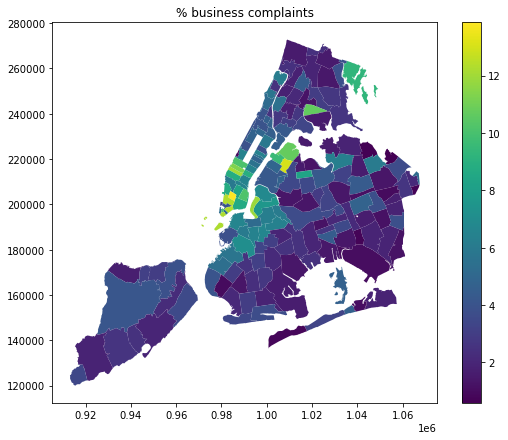

In [40]:
# plot as heatmap

comp_sales_plot = zips.merge(comp_sales, left_on='ZIPCODE', right_on='Incident Zip')
comp_sales_plot.plot(column='perc_complaints', figsize=(9,7), legend=True)
plt.title('% business complaints')

Text(0.5, 1.0, 'median price per sq.ft (USD)')

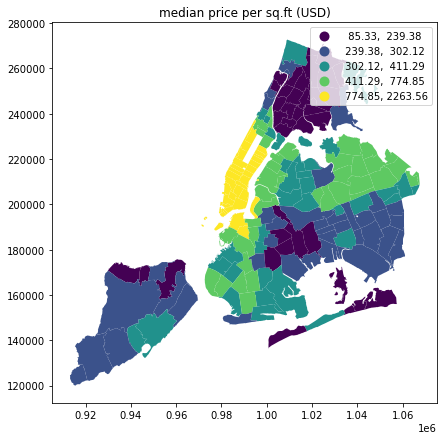

In [41]:
comp_sales_plot.plot(column='price_perSqf', scheme='quantiles', figsize=(9,7), legend=True)
plt.title('median price per sq.ft (USD)')

Both commercial complaints and high sale prices are concentrated in Manhattan, indicating centrality of the place could be a common cause for both...

## noise complaints vs. neighborhood real estate

Let's focus on 311 complaints regarding noise in particular and check if there's any relation between noise complaints amd the real estate market in an area.

In [42]:
# check the complaint types in the data

data['Complaint Type'].unique()

array(['Damaged Tree', 'Graffiti', 'Noise - Commercial', 'FATF',
       'Overgrown Tree/Branches', 'Lost Property', 'Rodent',
       'Illegal Parking', 'Broken Parking Meter',
       'Non-Emergency Police Matter', 'Blocked Driveway',
       'Noise - Residential', 'Street Condition', 'Sidewalk Condition',
       'Noise - Helicopter', 'Street Sign - Damaged',
       'Unsanitary Animal Pvt Property', 'For Hire Vehicle Complaint',
       'Street Sign - Dangling', 'Noise - Vehicle',
       'DEP Street Condition', 'Indoor Air Quality',
       'Root/Sewer/Sidewalk Condition', 'Violation of Park Rules',
       'Maintenance or Facility', 'Animal in a Park', 'Standing Water',
       'Homeless Person Assistance', 'Noise - Park',
       'DOF Property - Update Account', 'DOF Property - Request Copy',
       'New Tree Request', 'Dead/Dying Tree',
       'DOF Property - Reduction Issue', 'Abandoned Vehicle',
       'Water System', 'SCRIE', 'Sewer', 'DOF Parking - Tax Exemption',
       'DOF Property 

In [43]:
# The complaint type corresponding to noise is "Noise - Commercial", 'Noise - Residential', 'Noise' etc.

In [44]:
# create another column indicating the complaint type as just two groups - "noise" and "other" for every other complaint

noise_complaints = ['Noise - Commercial', 'Noise - Residential', 'Noise - Street/Sidewalk', 
                   'Noise', 'Noise - Vehicle', 'Noise - House of Worship', 'Noise - Helicopter', 'Noise - Park']

data['complaint_description'] = 'other'
data.loc[data['Complaint Type'].isin(noise_complaints), 'complaint_description'] = 'noise'
data.head()

,Unique Key,Created Date,Agency,Complaint Type,Location Type,Incident Zip,Latitude,Longitude,Location,complaint_hour,complaint_time,weekday,complaint_description,loc_description
1,44079566,2019-10-17 08:25:14,DPR,Damaged Tree,Street/Curbside,11434.0,40.670854,-73.771876,"(40.6708540271649, -73.77187597753328)",8,08:25:14,3,other,other
2,45211021,2019-12-20 06:54:38,DSNY,Graffiti,Mixed Use,11212.0,40.663072,-73.925752,"(40.66307167932628, -73.92575181328998)",6,06:54:38,4,other,other
3,45232110,2019-12-23 08:48:30,DSNY,Graffiti,Mixed Use,10016.0,40.744629,-73.976001,"(40.74462912186954, -73.97600102823421)",8,08:48:30,0,other,other
4,43573777,2019-08-17 02:30:39,DSNY,Graffiti,Residential,10032.0,40.835618,-73.945652,"(40.83561762599567, -73.9456520072136)",2,02:30:39,5,other,other
5,43524214,2019-08-11 23:46:01,NYPD,Noise - Commercial,Store/Commercial,11420.0,40.675929,-73.818015,"(40.67592902161404, -73.81801548500097)",23,23:46:01,6,noise,business


In [45]:
# now calculate the noise complaints as a % of total 311 complaints for each zip

complaint_perc = data.groupby(by=['Incident Zip', 'complaint_description']).count()[['Unique Key']]
complaint_perc = complaint_perc.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
complaint_perc.reset_index(inplace=True)
complaint_perc.rename(columns={'Unique Key':'perc_complaints'}, inplace=True)
complaint_perc.head()

,Incident Zip,complaint_description,perc_complaints
0,10001.0,noise,21.083212
1,10001.0,other,78.916788
2,10002.0,noise,33.788132
3,10002.0,other,66.211868
4,10003.0,noise,26.371992


In [46]:
# merge the income data with 311 business noise % complaints

complaint_perc_bus = complaint_perc.loc[complaint_perc.complaint_description == 'noise', :]
comp_income = complaint_perc_bus.merge(income, left_on='Incident Zip', right_on='Zipcode')
comp_income.head()

,Incident Zip,complaint_description,perc_complaints,Zipcode,IncomePerCapita
0,10001.0,noise,21.083212,10001,77512.0
1,10002.0,noise,33.788132,10002,26905.0
2,10003.0,noise,26.371992,10003,79088.0
3,10004.0,noise,8.137045,10004,98020.0
4,10005.0,noise,13.730356,10005,99633.0


In [47]:
comp_income[['perc_complaints', 'IncomePerCapita']].corr()

,perc_complaints,IncomePerCapita
perc_complaints,1.000000,-0.325744
IncomePerCapita,-0.325744,1.000000


In [48]:
# merge the income data with 311 business noise % complaints

complaint_perc_bus = complaint_perc.loc[complaint_perc.complaint_description == 'noise', :]
comp_sales = complaint_perc_bus.merge(sales_median, left_on='Incident Zip', right_on='ZIP CODE')
comp_sales.head()

,Incident Zip,complaint_description,perc_complaints,ZIP CODE,price_perSqf
0,10001.0,noise,21.083212,10001.0,1280.097512
1,10002.0,noise,33.788132,10002.0,1039.603960
2,10003.0,noise,26.371992,10003.0,1190.013196
3,10004.0,noise,8.137045,10004.0,1250.746215
4,10005.0,noise,13.730356,10005.0,1304.986441


In [49]:
comp_sales[['perc_complaints', 'price_perSqf']].corr()

,perc_complaints,price_perSqf
perc_complaints,1.000000,-0.248677
price_perSqf,-0.248677,1.000000


Text(0.5, 1.0, 'IncomePerCapita')

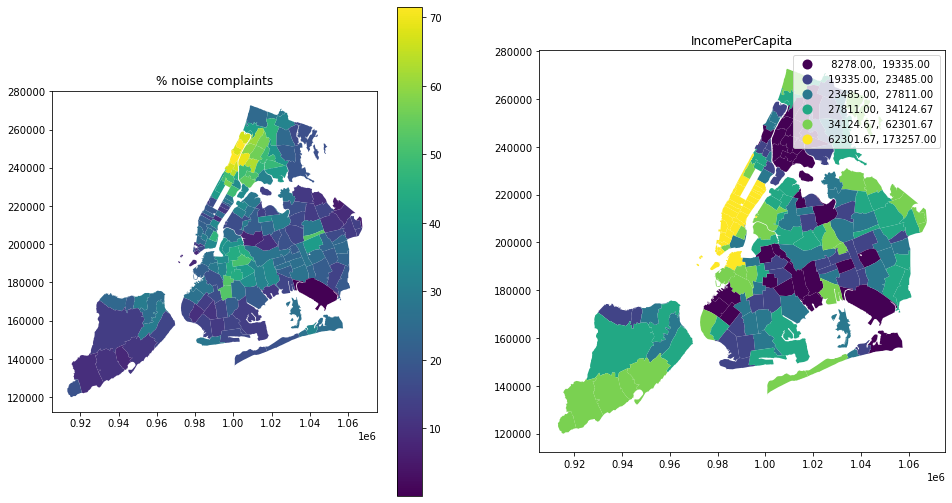

In [50]:
comp_sales_plot = zips.merge(comp_sales, left_on='ZIPCODE', right_on='Incident Zip')
comp_income_plot = zips.merge(comp_income, left_on='ZIPCODE', right_on='Incident Zip')

plt.figure(figsize=(16, 9))
ax1 = plt.subplot(1, 2, 1)
comp_sales_plot.plot(column='perc_complaints', figsize=(9,7), legend=True, ax=ax1)
plt.title('% noise complaints')

ax2 = plt.subplot(1, 2, 2)
comp_income_plot.plot(column='IncomePerCapita', scheme='quantiles', k=6, figsize=(9,7), legend=True, ax=ax2)
plt.title('IncomePerCapita')

Text(0.5, 1.0, 'price per sq ft')

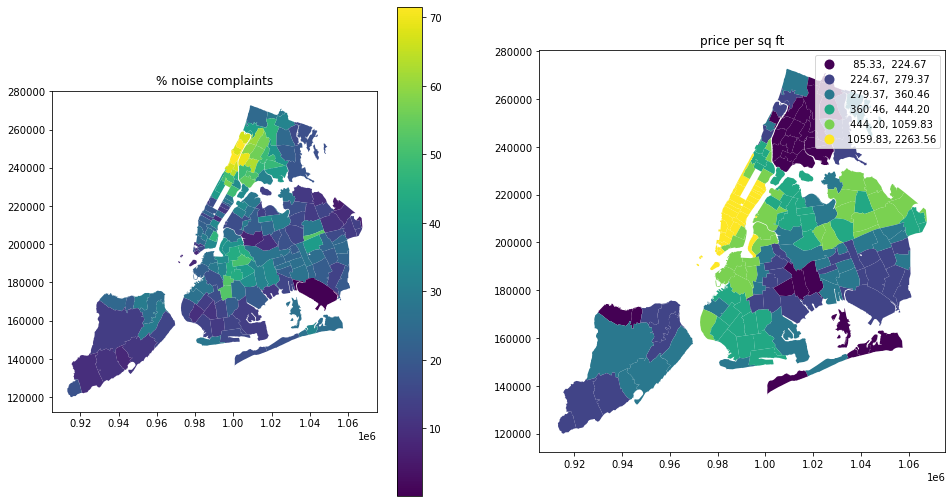

In [51]:
comp_sales_plot = zips.merge(comp_sales, left_on='ZIPCODE', right_on='Incident Zip')
comp_income_plot = zips.merge(comp_income, left_on='ZIPCODE', right_on='Incident Zip')

plt.figure(figsize=(16, 9))
ax1 = plt.subplot(1, 2, 1)
comp_sales_plot.plot(column='perc_complaints', figsize=(9,7), legend=True, ax=ax1)
plt.title('% noise complaints')

ax2 = plt.subplot(1, 2, 2)
comp_sales_plot.plot(column='price_perSqf', scheme='quantiles', k=6, figsize=(9,7), legend=True, ax=ax2)
plt.title('price per sq ft')